In [66]:

import numpy as np
import random

import gym
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal

import torch.optim as optim
import time
from torch.utils.tensorboard import SummaryWriter
import argparse

# Networks

In [217]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=32, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        torch.manual_seed(seed)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)


    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)

    def forward(self, state):

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)

        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def sample(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        e = dist.rsample().to(device)
        action = torch.tanh(e)
        log_prob = (dist.log_prob(e) - torch.log(1 - action.pow(2) + epsilon)).sum(1, keepdim=True)

        return action, log_prob, torch.tanh(mu)
        

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers
        """
        super(Critic, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size+action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Regular SAC Agent for comparison

In [221]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, action_prior="uniform"):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.target_entropy = -action_size  # -dim(A)
        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha = self.log_alpha.exp().detach()
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=lr) 
        self._action_prior = action_prior
        self.alphas = []
        print("Using: ", device)
        
        # Actor Network 
        self.actor_local = Actor(state_size, action_size, random_seed, hidden_size=256).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr)     
        
        # Critic Network (w/ Target Network)
        self.critic1 = Critic(state_size, action_size, random_seed, hidden_size=256).to(device)
        self.critic2 = Critic(state_size, action_size, random_seed+1, hidden_size=256).to(device)
        
        self.critic1_target = Critic(state_size, action_size, random_seed, hidden_size=256).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = Critic(state_size, action_size, random_seed+1, hidden_size=256).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=lr, weight_decay=0)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=lr, weight_decay=0) 

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, random_seed)
        

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > batch_size:
            experiences = self.memory.sample()
            self.learn(1, experiences, gamma)
            
    
    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        action, _, _ = self.actor_local.sample(state)
        return action.detach().cpu()[0]
    
    def eval(self, state):
        state = torch.from_numpy(state).float().to(device)
        _, _ , action = self.actor_local.sample(state)
        return action.detach().cpu()[0]
    
    def learn(self, step, experiences, gamma, d=1):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        

        # ---------------------------- update critic ---------------------------- #

        with torch.no_grad():
            # Get predicted next-state actions and Q values from target models
            next_action, next_log_prob, _ = self.actor_local.sample(next_states)
            Q_target1_next = self.critic1_target(next_states.to(device), next_action.squeeze(0).to(device))
            Q_target2_next = self.critic2_target(next_states.to(device), next_action.squeeze(0).to(device))
            # take the min of both critics for updating
            Q_target_next = torch.min(Q_target1_next, Q_target2_next) - self.alpha.to(device) * next_log_prob

        Q_targets = rewards.cpu() + (gamma * (1 - dones.cpu()) * Q_target_next.cpu())

        # Compute critic loss
        Q_1 = self.critic1(states, actions).cpu()
        Q_2 = self.critic2(states, actions).cpu()
        critic1_loss = 0.5*F.mse_loss(Q_1, Q_targets)
        critic2_loss = 0.5*F.mse_loss(Q_2, Q_targets)
        
        # Update critics
        # critic 1
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        # critic 2
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        if step % d == 0:
        # ---------------------------- update actor ---------------------------- #

            actions_pred, log_prob, _ = self.actor_local.sample(states)             
  
            Q1 = self.critic1(states, actions_pred.squeeze(0)).cpu()
            Q2 = self.critic2(states, actions_pred.squeeze(0)).cpu()
            Q = torch.min(Q1,Q2)

            actor_loss = (self.alpha * log_prob.cpu() - Q ).mean()
            # Optimize the actor loss
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            # Compute alpha loss 
            alpha_loss = - (self.log_alpha.exp() * (log_prob.cpu() + self.target_entropy).detach().cpu()).mean()
    
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp().detach()
            self.alphas.append(self.alpha.detach())

            # ----------------------- update target networks ----------------------- #
            self.soft_update(self.critic1, self.critic1_target)
            self.soft_update(self.critic2, self.critic2_target)
                     

    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [222]:
    
def train(n_episodes=200, print_every=10):
    scores_deque = deque(maxlen=100)
    average_100_scores = []
    scores = []
    for i_episode in range(1, n_episodes+1):

        state = env.reset()
        state = state.reshape((1, state_size))
        score = 0
        while True:
            
            action = agent.act(state)
            action_v = action.numpy()
            action_v = np.clip(action_v, action_low, action_high)
            next_state, reward, done, info = env.step(action_v)
            next_state = next_state.reshape((1, state_size))
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break 

        scores_deque.append(score)
        scores.append(score)
        average_100_scores.append(np.mean(scores_deque))
        
        print('\rEpisode {} Reward: {:.2f}  Average100 Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
            
    return scores

# Train SAC

In [227]:
import pybulletgym
env_name = "Pendulum-v0" #"HalfCheetahPyBulletEnv-v0"#"Pendulum-v0"
ep = 100
seed = 0
#Hyperparameter
lr = 3e-4
buffer_size = int(1e6)
batch_size = 256
tau = 0.005
gamma = 0.99


#writer = SummaryWriter("runs/"+args.info)
env = gym.make(env_name)
action_high = env.action_space.high[0]
action_low = env.action_space.low[0]
torch.manual_seed(seed)
env.seed(seed)
np.random.seed(seed)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
agent = Agent(state_size=state_size,
              action_size=action_size,
              random_seed=seed,
              action_prior="uniform")

t0 = time.time()
sac_scores = train(n_episodes=ep)
t1 = time.time()
env.close()
print("training took {} min!".format((t1-t0)/60))


Using:  cuda:0
Episode 10  Reward: -1694.14  Average100 Score: -1390.15
Episode 20  Reward: -1073.39  Average100 Score: -1236.83
Episode 30  Reward: -1081.98  Average100 Score: -1173.45
Episode 40  Reward: -364.82  Average100 Score: -1044.72
Episode 50  Reward: -126.32  Average100 Score: -889.91
Episode 60  Reward: -358.29  Average100 Score: -798.15
Episode 70  Reward: -241.25  Average100 Score: -723.77
Episode 80  Reward: -124.98  Average100 Score: -662.06
Episode 90  Reward: -246.24  Average100 Score: -623.62
Episode 100  Reward: -580.32  Average100 Score: -586.80
training took 4.617990879217784 min!


In [ ]:
-586 avg, 4.5 min!

Text(0, 0.5, 'Reward')

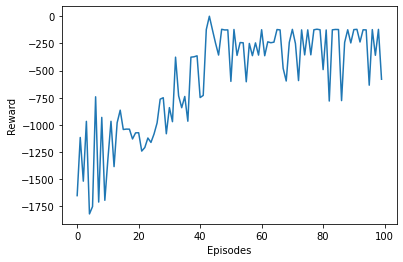

In [228]:
import matplotlib.pyplot as plt
plt.plot(sac_scores)

plt.xlabel("Episodes")
plt.ylabel("Reward")

# Randomized Ensembled Double Q-learning (REDQ)

In [233]:
class REDQ_Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, action_prior="uniform", N=2, M=2, G=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.target_entropy = -action_size  # -dim(A)
        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha = self.log_alpha.exp().detach()
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=lr) 
        self._action_prior = action_prior
        self.alphas = []
        print("Using: ", device)
        
        # REDQ parameter
        self.N = N # number of critics in the ensemble
        self.M = M # number of target critics that are randomly selected
        self.G = G # Updates per step ~ UTD-ratio
        
        # Actor Network 
        self.actor_local = Actor(state_size, action_size, random_seed, hidden_size=256).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr)     
        
        # Critic Network (w/ Target Network)
        self.critics = []
        self.target_critics = []
        self.optims = []
        for i in range(self.N):
            critic = Critic(state_size, action_size, i, hidden_size=256).to(device)

            optimizer = optim.Adam(critic.parameters(), lr=lr, weight_decay=0)
            self.optims.append(optimizer)
            self.critics.append(critic)
            target = Critic(state_size, action_size, i, hidden_size=256).to(device)
            self.target_critics.append(target)


        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, random_seed)
        

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        for update in range(self.G):
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(update, experiences, gamma)
            
    
    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        action, _, _ = self.actor_local.sample(state)
        return action.detach().cpu()[0]
    
    def eval(self, state):
        state = torch.from_numpy(state).float().to(device)
        _, _ , action = self.actor_local.sample(state)
        return action.detach().cpu()[0]
    
    def learn(self, step, experiences, gamma):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # sample target critics
        idx = np.random.choice(len(self.critics), self.M, replace=False) # replace=False so that not picking the same idx twice
        

        # ---------------------------- update critic ---------------------------- #

        with torch.no_grad():
            # Get predicted next-state actions and Q values from target models
            next_action, next_log_prob, _ = self.actor_local.sample(next_states)
            # TODO: make this variable for possible more than two target critics
            Q_target1_next = self.target_critics[idx[0]](next_states.to(device), next_action.squeeze(0).to(device))
            Q_target2_next = self.target_critics[idx[1]](next_states.to(device), next_action.squeeze(0).to(device))
            
            # take the min of both critics for updating
            Q_target_next = torch.min(Q_target1_next, Q_target2_next) - self.alpha.to(device) * next_log_prob

        Q_targets = rewards.cpu() + (gamma * (1 - dones.cpu()) * Q_target_next.cpu())

        # Compute critic losses and update critics 
        for critic, optim, target in zip(self.critics, self.optims, self.target_critics):
            Q = critic(states, actions).cpu()
            Q_loss = 0.5*F.mse_loss(Q, Q_targets)
        
            # Update critic
            optim.zero_grad()
            Q_loss.backward()
            optim.step()
            # soft update of the targets
            self.soft_update(critic, target)
        
        # ---------------------------- update actor ---------------------------- #
        if step == self.G-1:

            actions_pred, log_prob, _ = self.actor_local.sample(states)             
            
            # TODO: make this variable for possible more than two critics
            Q1 = self.critics[idx[0]](states, actions_pred.squeeze(0)).cpu()
            Q2 = self.critics[idx[0]](states, actions_pred.squeeze(0)).cpu()
            Q = torch.min(Q1,Q2)

            actor_loss = (self.alpha * log_prob.cpu() - Q ).mean()
            # Optimize the actor loss
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Compute alpha loss 
            alpha_loss = - (self.log_alpha.exp() * (log_prob.cpu() + self.target_entropy).detach().cpu()).mean()

            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp().detach()
            self.alphas.append(self.alpha.detach())


    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [235]:
import pybulletgym
env_name = "Pendulum-v0" #"HalfCheetahPyBulletEnv-v0"#"Pendulum-v0"
ep = 100
seed = 1
#Hyperparameter
lr = 3e-4
buffer_size = int(1e6)
batch_size = 256
tau = 0.005
gamma = 0.99

# RED-Q Parameter
N = 5
M = 2
G = 5

#writer = SummaryWriter("runs/"+args.info)
env = gym.make(env_name)
action_high = env.action_space.high[0]
action_low = env.action_space.low[0]
torch.manual_seed(seed)
env.seed(seed)
np.random.seed(seed)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
agent = REDQ_Agent(state_size=state_size,
              action_size=action_size,
              random_seed=seed,
              action_prior="uniform", N=N, M=M, G=G)

t0 = time.time()
scores = train(n_episodes=ep)
t1 = time.time()
env.close()
print("training took {} min!".format((t1-t0)/60))


Using:  cuda:0
Episode 10  Reward: -1220.98  Average100 Score: -1250.16
Episode 20  Reward: -799.08  Average100 Score: -1166.32
Episode 30  Reward: -125.80  Average100 Score: -1028.61
Episode 40  Reward: -242.82  Average100 Score: -843.07
Episode 50  Reward: -603.70  Average100 Score: -743.37
Episode 60  Reward: -125.64  Average100 Score: -658.70
Episode 70  Reward: -487.96  Average100 Score: -617.03
Episode 80  Reward: -484.87  Average100 Score: -582.52
Episode 90  Reward: -121.03  Average100 Score: -549.30
Episode 100  Reward: -616.42  Average100 Score: -517.58
training took 26.54071460167567 min!


## Comparison plot

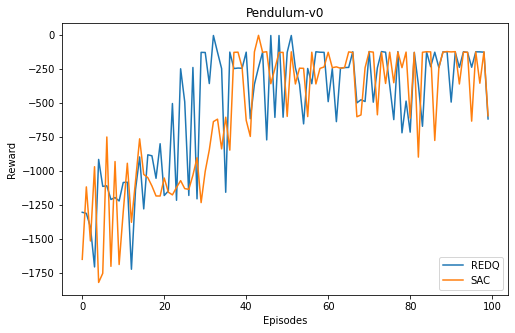

In [239]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.title("Pendulum-v0")
plt.plot(scores, label="REDQ")
#plt.plot(sac_ensemble, color="r", label="SAC_Ensemble")
plt.plot(sac_scores, label="SAC")

plt.legend(loc=4)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.savefig("Pendulum_REDQ_5-2-5.jpg")